# Model Testing

This notebook outlines the performance of our XGBoost model constructed using our engineered features from the dataset, as well as the performance of other models which we tested in the early stages of choosing a model. The XGBoost model performance is given first, followed by the predecessing alternatives which were tested. 

### Dataset Retrieval

In [15]:
import pandas as pd

# Read the CSV file with a specified encoding
df = pd.read_csv("cleaned_flight_data.csv", encoding="ISO-8859-1", low_memory=False)

# Display the first 5 rows
df.head()

,Year,Quarter,Month,DayofMonth,DayOfWeek,FlightDate,Reporting_Airline,DOT_ID_Reporting_Airline,IATA_CODE_Reporting_Airline,Tail_Number,Flight_Number_Reporting_Airline,OriginAirportID,OriginAirportSeqID,OriginCityMarketID,Origin,OriginCityName,OriginState,OriginStateFips,OriginStateName,OriginWac,DestAirportID,DestAirportSeqID,DestCityMarketID,Dest,DestCityName,DestState,DestStateFips,DestStateName,DestWac,CRSDepTime,DepTime,DepDelay,DepDelayMinutes,DepDel15,DepartureDelayGroups,DepTimeBlk,TaxiOut,WheelsOff,WheelsOn,TaxiIn,CRSArrTime,ArrTime,ArrDelay,ArrDelayMinutes,ArrDel15,ArrivalDelayGroups,ArrTimeBlk,Cancelled,CancellationCode,Diverted,CRSElapsedTime,ActualElapsedTime,AirTime,Flights,Distance,DistanceGroup,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,FirstDepTime,TotalAddGTime,LongestAddGTime,DivAirportLandings,DivReachedDest,DivActualElapsedTime,DivArrDelay,DivDistance,Div1Airport,Div1AirportID,Div1AirportSeqID,Div1WheelsOn,Div1TotalGTime,Div1LongestGTime,Div1WheelsOff,Div1TailNum,Div2Airport,Div2AirportID,Div2AirportSeqID,Div2WheelsOn,Div2TotalGTime,Div2LongestGTime,Div2WheelsOff,Div2TailNum
0,1998,1,1,2,5,1998-01-02,NW,19386,NW,N297US,675,13487,1348701,31650,MSP,"Minneapolis, MN",MN,27.0,Minnesota,63,14869,1486902,34614,SLC,"Salt Lake City, UT",UT,49.0,Utah,87,1000,1019.0,19.0,19.0,1.0,1.0,1600-1659,24.0,1043.0,1136.0,3.0,1116,1139.0,23.0,23.0,1.0,1.0,1800-1859,0.0,unknown,0.0,176.0,180.0,153.0,1.0,991.0,4,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2009,2,5,28,4,2009-05-28,FL,20437,FL,N946AT,671,13342,1334202,33342,MKE,"Milwaukee, WI",WI,55.0,Wisconsin,45,13204,1320401,31454,MCO,"Orlando, FL",FL,12.0,Florida,33,724,722.0,-2.0,0.0,0.0,-1.0,1200-1259,10.0,732.0,933.0,8.0,941,941.0,0.0,0.0,0.0,0.0,1500-1559,0.0,unknown,0.0,157.0,159.0,141.0,1.0,1066.0,5,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2013,2,6,29,6,2013-06-29,MQ,20398,MQ,N665MQ,3297,11921,1192102,31921,GJT,"Grand Junction, CO",CO,8.0,Colorado,82,11298,1129803,30194,DFW,"Dallas/Fort Worth, TX",TX,48.0,Texas,74,990,1004.0,14.0,14.0,0.0,0.0,1600-1659,9.0,1013.0,1176.0,6.0,1185,1182.0,-3.0,0.0,0.0,-1.0,1900-1959,0.0,unknown,0.0,135.0,118.0,103.0,1.0,773.0,4,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2010,3,8,31,2,2010-08-31,DL,19790,DL,N6705Y,1806,12892,1289201,32575,LAX,"Los Angeles, CA",CA,6.0,California,91,11433,1143301,31295,DTW,"Detroit, MI",MI,26.0,Michigan,43,785,785.0,0.0,0.0,0.0,0.0,1300-1359,23.0,808.0,1208.0,7.0,1235,1215.0,-20.0,0.0,0.0,-2.0,2000-2059,0.0,unknown,0.0,270.0,250.0,220.0,1.0,1979.0,8,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2006,1,1,15,7,2006-01-15,US,20355,US,N504AU,465,11618,1161801,31703,EWR,"Newark, NJ",NJ,34.0,New Jersey,21,11057,1105702,31057,CLT,"Charlotte, NC",NC,37.0,North Carolina,36,1100,1151.0,51.0,51.0,1.0,3.0,1800-1859,19.0,1170.0,1250.0,8.0,1226,1258.0,32.0,32.0,1.0,2.0,2000-2059,0.0,unknown,0.0,126.0,107.0,80.0,1.0,529.0,3,0.0,0.0,0.0,0.0,32.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from xgboost import XGBClassifier

### Preprocessing

In [17]:
# Fill missing values for numerical columns
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns
df[numerical_cols] = df[numerical_cols].fillna(df[numerical_cols].median())

In [18]:
# Create binary target variable 'DelayCategory': 1 if there was an arrival delay (ArrDelay > 0), 0 if there wasn't
df['DelayCategory'] = df.apply(lambda row: 1 if row['ArrDelay'] > 0 else 0, axis=1)

In [19]:
# Display the count of each class in the target variable
delay_counts = df['DelayCategory'].value_counts()

print("Target Variable Distribution:")
print(f"On-Time Flights (0): {delay_counts[0]}")
print(f"Delayed Flights (1): {delay_counts[1]}")

# show percentage distribution
delay_percentages = df['DelayCategory'].value_counts(normalize=True) * 100
print("\nPercentage Distribution:")
print(f"On-Time Flights (0): {delay_percentages[0]:.2f}%")
print(f"Delayed Flights (1): {delay_percentages[1]:.2f}%")

Target Variable Distribution:
On-Time Flights (0): 1140446
Delayed Flights (1): 859554

Percentage Distribution:
On-Time Flights (0): 57.02%
Delayed Flights (1): 42.98%


In [5]:
# Encode 'DelayCategory'
le = LabelEncoder()
df['DelayCategory'] = le.fit_transform(df['DelayCategory'])

### Feature Engineering Steps

In [16]:
# --- Feature Engineering (Time-related and Categorical Features) ---

# Convert CRS (Scheduled) arrival time to minutes since midnight
df['CRSArrTime_combined'] = df['CRSArrTime'] // 100 * 60 + df['CRSArrTime'] % 100

# Time of day: 6 AM to 2 PM window for scheduled arrival
df['DayArrivalFlight'] = df['CRSArrTime_combined'].apply(lambda x: 1 if 360 <= x <= 840 else 0)

# Seasonal features (months with higher delay rates)
df['HighDelaySeason'] = df['Month'].apply(lambda x: 1 if x in [1, 3, 6, 7, 12] else 0)

# Weekend flag (Saturday and Sunday)
df['IsWeekend'] = df['DayOfWeek'].apply(lambda x: 1 if x in [5, 6] else 0)

# Airline-based delay flag
df['HighDelayAirline'] = df['IATA_CODE_Reporting_Airline'].apply(lambda x: 1 if x in ['PI', 'AL', 'AA', 'B6','PS'] else 0)

# High-delay weekdays: Wednesday and Thursday
df['HighDelayWeekday'] = df['DayOfWeek'].apply(lambda x: 1 if x in [3, 4] else 0)

# State-based flags
high_delay_origin_states = ['CA', 'TX', 'IL', 'FL', 'GA', 'NY', 'CO', 'NC', 'PA', 'AZ']
high_delay_dest_states = ['CA', 'TX', 'FL', 'IL', 'GA', 'NY', 'NC', 'CO', 'PA', 'AZ']

df['HighDelayOriginState'] = df['OriginState'].apply(lambda x: 1 if x in high_delay_origin_states else 0)
df['HighDelayDestState'] = df['DestState'].apply(lambda x: 1 if x in high_delay_dest_states else 0)

# --- Aggregated Delay Rates (Historical Averages) ---
# Airline average delay rate
carrier_delay_rate = df.groupby('IATA_CODE_Reporting_Airline')['DelayCategory'].mean()
df['AirlineDelayRate'] = df['IATA_CODE_Reporting_Airline'].map(carrier_delay_rate)

# Origin state average delay rate
origin_delay_rate = df.groupby('OriginState')['DelayCategory'].mean()
df['OriginStateDelayRate'] = df['OriginState'].map(origin_delay_rate)

# Destination state average delay rate
dest_delay_rate = df.groupby('DestState')['DelayCategory'].mean()
df['DestStateDelayRate'] = df['DestState'].map(dest_delay_rate)

# Weather delay rate by route (Origin-Destination pair)
df['Route'] = df['Origin'] + '-' + df['Dest']  # Combine Origin and Destination for the route
weather_delay_rate = df.groupby('Route')['WeatherDelay'].mean()
df['WeatherDelayRate'] = df['Route'].map(weather_delay_rate)

# Calculate NAS delay rate by route (Origin-Destination pair)
df['Route'] = df['Origin'] + '-' + df['Dest']  # Create a new column for Route (Origin-Destination)
nas_delay_rate_by_route = df.groupby('Route')['NASDelay'].mean()
df['NASDelayRate'] = df['Route'].map(nas_delay_rate_by_route)

# Late aircraft delay rate by airline
late_aircraft_delay_rate = df.groupby('IATA_CODE_Reporting_Airline')['LateAircraftDelay'].mean()
df['LateAircraftDelayRate'] = df['IATA_CODE_Reporting_Airline'].map(late_aircraft_delay_rate)

# --- Highest Delayed Flight Number Feature ---
# Aggregate the total delay count for each Flight_Number_Reporting_Airline
flight_delay_sum = df.groupby('Flight_Number_Reporting_Airline')['DelayCategory'].sum().reset_index()

# Sort the flights by the total delay count, descending, to get the highest delayed flights first
flight_delay_sum = flight_delay_sum.sort_values(by='DelayCategory', ascending=False)

# Assign a new column with the flight numbers that have the highest delays (ranked by sum of delays)
# Create a new feature: 'HighestDelayedFlightNumber'
df['HighestDelayedFlightNumber'] = df['Flight_Number_Reporting_Airline'].map(flight_delay_sum.set_index('Flight_Number_Reporting_Airline')['DelayCategory'])

# --- Final Feature Set ---

features = ['Year', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 'CRSElapsedTime', 'Distance', 
    'HighDelaySeason', 'DayArrivalFlight', 'IsWeekend', 'HighDelayAirline', 'HighDelayOriginState', 
    'HighDelayDestState', 'HighDelayWeekday', 'AirlineDelayRate', 'OriginStateDelayRate', 'DestStateDelayRate',
    'WeatherDelayRate', 'NASDelayRate', 'LateAircraftDelayRate', 'HighestDelayedFlightNumber']

# Features and target
X = df[features]
y = df['DelayCategory']

In [17]:
# Label encode any object/categorical columns (just in case)
label_encoder = LabelEncoder()
for col in X.select_dtypes(include=['object']).columns:
    X[col] = label_encoder.fit_transform(X[col].astype(str))

# Fill any remaining missing values
X = X.fillna(X.median())

# --- Standardization (important for Logistic Regression) ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

### Training-test Split + Scaling

In [18]:
# --- Train-test split (Stratified Split) ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [19]:
# --- Scaling: Fit scaler on training data and transform both train and test sets ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

ratio_of_classes = len(y_train[y_train == 0]) / len(y_train[y_train == 1])

### XGBoost

In [20]:
# --- XGBoost model with tuned parameters ---
xgb_model = XGBClassifier(
    use_label_encoder=False,
    eval_metric='map',
    n_estimators=1000,
    tree_method='hist',
    verbosity=0,
    random_state=42,
    scale_pos_weight=ratio_of_classes
)

# Train the model
xgb_model.fit(X_train_scaled, y_train)

# --- Get predicted probabilities --- 
y_pred_prob = xgb_model.predict_proba(X_test_scaled)[:, 1]  # Get probabilities for class 1 (delayed flights)

# --- Set a custom threshold for classification --- 
threshold = 0.5
y_pred_class = (y_pred_prob >= threshold).astype(int)

# --- Print F1 score ---
f1 = f1_score(y_test, y_pred_class, average='weighted')
print("XGBoost F1 Score (weighted):", f1)

# --- Print classification report ---
print("\nXGBoost Classification Report:")
print(classification_report(y_test, y_pred_class))

# --- Print confusion matrix ---
print("\nXGBoost Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_class))

XGBoost F1 Score (weighted): 0.6113493476131662

XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.62      0.64    228089
           1       0.54      0.60      0.57    171911

    accuracy                           0.61    400000
   macro avg       0.61      0.61      0.61    400000
weighted avg       0.62      0.61      0.61    400000


XGBoost Confusion Matrix:
[[141373  86716]
 [ 69407 102504]]


### Feature Importance Analysis

Top 10 Features by Importance:
                  Feature  Importance
0                    Year    0.091797
7         HighDelaySeason    0.079118
8        DayArrivalFlight    0.075791
14       AirlineDelayRate    0.074504
4               DayOfWeek    0.055042
19  LateAircraftDelayRate    0.050403
2                   Month    0.048889
1                 Quarter    0.048665
15   OriginStateDelayRate    0.042887
6                Distance    0.041861


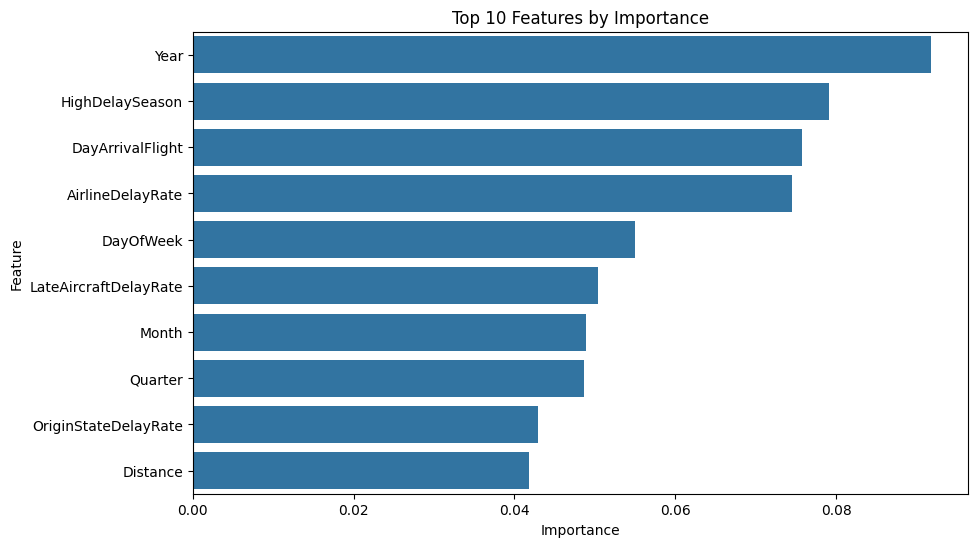

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns 

# --- Get feature importance ---
feature_importance = xgb_model.feature_importances_

# --- Sort the features by importance ---
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importance
})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# --- Print the top features ---
print("Top 10 Features by Importance:")
print(importance_df.head(10))

# --- Plot feature importance using matplotlib ---
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(10))  # Top 10 features
plt.title('Top 10 Features by Importance')
plt.show()

### Model Probability Result + Prediction Testing

In this section, we assessed the model's performance with raw input values to analyze the strength of its prediction and probability threshold given for delays and non-delays. 

In [ ]:
import numpy as np
import pandas as pd

# --- Sample raw input dictionary (replace these with user input values) ---
raw_input = {
    'Year': 2022,
    'Quarter': 3,
    'Month': 12,
    'DayofMonth': 15,
    'DayOfWeek': 3,
    'CRSElapsedTime': 180,
    'Distance': 1000,
    'ArrTime': 930,  # 9:30 AM
    'IATA_CODE_Reporting_Airline': 'PL',
    'Origin': 'LAX',
    'Dest': 'JFK',
    'OriginState': 'CA',
    'DestState': 'NY',
    'Flight_Number_Reporting_Airline': '1234'
}

# --- Create one-row DataFrame ---
input_df = pd.DataFrame([raw_input])

# --- Feature Engineering ---
input_df['ArrTime_combined'] = input_df['ArrTime'] // 100 * 60 + input_df['ArrTime'] % 100
input_df['DayArrivalFlight'] = input_df['ArrTime_combined'].apply(lambda x: 1 if 360 <= x <= 840 else 0)
input_df['HighDelaySeason'] = input_df['Month'].apply(lambda x: 1 if x in [1, 3, 6, 7, 12] else 0)
input_df['IsWeekend'] = input_df['DayOfWeek'].apply(lambda x: 1 if x in [5, 6] else 0)
input_df['HighDelayAirline'] = input_df['IATA_CODE_Reporting_Airline'].apply(lambda x: 1 if x in ['PI', 'AL', 'AA', 'B6', 'PS'] else 0)
input_df['HighDelayWeekday'] = input_df['DayOfWeek'].apply(lambda x: 1 if x in [3, 4] else 0)

# Delay-prone states
high_delay_origin_states = ['CA', 'TX', 'IL', 'FL', 'GA', 'NY', 'CO', 'NC', 'PA', 'AZ']
high_delay_dest_states = ['CA', 'TX', 'FL', 'IL', 'GA', 'NY', 'NC', 'CO', 'PA', 'AZ']
input_df['HighDelayOriginState'] = input_df['OriginState'].apply(lambda x: 1 if x in high_delay_origin_states else 0)
input_df['HighDelayDestState'] = input_df['DestState'].apply(lambda x: 1 if x in high_delay_dest_states else 0)

# Route
input_df['Route'] = input_df['Origin'] + '-' + input_df['Dest']

# --- Map delay rates from training data ---
input_df['AirlineDelayRate'] = input_df['IATA_CODE_Reporting_Airline'].map(carrier_delay_rate)
input_df['OriginStateDelayRate'] = input_df['OriginState'].map(origin_delay_rate)
input_df['DestStateDelayRate'] = input_df['DestState'].map(dest_delay_rate)
input_df['WeatherDelayRate'] = input_df['Route'].map(weather_delay_rate)
input_df['NASDelayRate'] = input_df['Route'].map(nas_delay_rate_by_route)
input_df['LateAircraftDelayRate'] = input_df['IATA_CODE_Reporting_Airline'].map(late_aircraft_delay_rate)
input_df['HighestDelayedFlightNumber'] = input_df['Flight_Number_Reporting_Airline'].map(
    flight_delay_sum.set_index('Flight_Number_Reporting_Airline')['DelayCategory']
)

# Handle missing values
input_df.fillna(0, inplace=True)

# --- Final features for model ---
features = ['Year', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 'CRSElapsedTime', 'Distance',
    'HighDelaySeason', 'DayArrivalFlight', 'IsWeekend', 'HighDelayAirline', 'HighDelayOriginState', 
    'HighDelayDestState', 'HighDelayWeekday', 'AirlineDelayRate', 'OriginStateDelayRate', 'DestStateDelayRate',
    'WeatherDelayRate', 'NASDelayRate', 'LateAircraftDelayRate', 'HighestDelayedFlightNumber']

# --- Scale + Predict ---
X_input_scaled = scaler.transform(input_df[features])
prob = xgb_model.predict_proba(X_input_scaled)[0][1]
pred = int(prob >= threshold)

print(f"Predicted probability of delay: {prob:.2f}")
print("Prediction:", "Delayed" if pred == 1 else "On-Time")

Predicted probability of delay: 0.82
Prediction: Delayed


In [ ]:
import numpy as np
import pandas as pd

# --- Sample raw input dictionary (replace these with user input values) ---
raw_input = {
    'Year': 2022,
    'Quarter': 3,
    'Month': 7,
    'DayofMonth': 15,
    'DayOfWeek': 3,
    'CRSElapsedTime': 180,
    'AirTime': 160,
    'Distance': 1000,
    'ArrTime': 930,  # 9:30 AM
    'IATA_CODE_Reporting_Airline': 'AA',
    'Origin': 'LAX',
    'Dest': 'JFK',
    'OriginState': 'CA',
    'DestState': 'NY',
    'Flight_Number_Reporting_Airline': '1234'
}

# --- Create one-row DataFrame ---
input_df = pd.DataFrame([raw_input])

# --- Feature Engineering: replicate exact logic used during training ---

# Time in minutes since midnight
input_df['ArrTime_combined'] = input_df['ArrTime'] // 100 * 60 + input_df['ArrTime'] % 100
input_df['DayArrivalFlight'] = input_df['ArrTime_combined'].apply(lambda x: 1 if 360 <= x <= 840 else 0)

# Seasonal & weekend features
input_df['HighDelaySeason'] = input_df['Month'].apply(lambda x: 1 if x in [1, 3, 6, 7, 12] else 0)
input_df['IsWeekend'] = input_df['DayOfWeek'].apply(lambda x: 1 if x in [5, 6] else 0)
input_df['HighDelayAirline'] = input_df['IATA_CODE_Reporting_Airline'].apply(lambda x: 1 if x in ['PI', 'AL', 'AA', 'B6','PS'] else 0)
input_df['HighDelayWeekday'] = input_df['DayOfWeek'].apply(lambda x: 1 if x in [3, 4] else 0)

# State delay flags
high_delay_origin_states = ['CA', 'TX', 'IL', 'FL', 'GA', 'NY', 'CO', 'NC', 'PA', 'AZ']
high_delay_dest_states = ['CA', 'TX', 'FL', 'IL', 'GA', 'NY', 'NC', 'CO', 'PA', 'AZ']
input_df['HighDelayOriginState'] = input_df['OriginState'].apply(lambda x: 1 if x in high_delay_origin_states else 0)
input_df['HighDelayDestState'] = input_df['DestState'].apply(lambda x: 1 if x in high_delay_dest_states else 0)

# Route
input_df['Route'] = input_df['Origin'] + '-' + input_df['Dest']

# --- Map historical average features from training data ---

# These variables must come from training data
input_df['AirlineDelayRate'] = input_df['IATA_CODE_Reporting_Airline'].map(carrier_delay_rate)
input_df['OriginStateDelayRate'] = input_df['OriginState'].map(origin_delay_rate)
input_df['DestStateDelayRate'] = input_df['DestState'].map(dest_delay_rate)
input_df['WeatherDelayRate'] = input_df['Route'].map(weather_delay_rate)
input_df['NASDelayRate'] = input_df['Route'].map(nas_delay_rate_by_route)
input_df['LateAircraftDelayRate'] = input_df['IATA_CODE_Reporting_Airline'].map(late_aircraft_delay_rate)
input_df['HighestDelayedFlightNumber'] = input_df['Flight_Number_Reporting_Airline'].map(
    flight_delay_sum.set_index('Flight_Number_Reporting_Airline')['DelayCategory']
)

# Fill any missing values from mapping with 0 (optional fallback)
input_df.fillna(0, inplace=True)

# --- Final selected features for model input ---
features = ['Year', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 'CRSElapsedTime', 'Distance',
    'HighDelaySeason', 'DayArrivalFlight', 'IsWeekend', 'HighDelayAirline', 'HighDelayOriginState', 
    'HighDelayDestState', 'HighDelayWeekday', 'AirlineDelayRate', 'OriginStateDelayRate', 'DestStateDelayRate',
    'WeatherDelayRate', 'NASDelayRate', 'LateAircraftDelayRate', 'HighestDelayedFlightNumber']

# --- Scale features ---
X_input_scaled = scaler.transform(input_df[features])

# --- Predict ---
prob = xgb_model.predict_proba(X_input_scaled)[0][1]
pred = int(prob >= threshold)

print(f"Predicted probability of delay: {prob:.2f}")
print("Prediction:", "Delayed" if pred == 1 else "On-Time")

Predicted probability of delay: 0.45
Prediction: On-Time


### Preview of Models Tested Prior to our choice of XGBoost

In [23]:
# --- Logistic Regression Model ---
logreg = LogisticRegression(max_iter=2000, class_weight='balanced', random_state=42)
logreg.fit(X_train_scaled, y_train)

# --- Predictions and Evaluation ---
y_pred = logreg.predict(X_test_scaled)

print("Classification Report:")
print(classification_report(y_test, y_pred))
print ("Confusion Matrix: ")
print(confusion_matrix(y_test, y_pred))

print("Accuracy Score:", accuracy_score(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.56      0.60    228089
           1       0.49      0.57      0.53    171911

    accuracy                           0.56    400000
   macro avg       0.56      0.57      0.56    400000
weighted avg       0.57      0.56      0.57    400000

Confusion Matrix: 
[[128406  99683]
 [ 74379  97532]]
Accuracy Score: 0.564845


In [24]:
f1 = f1_score(y_test, y_pred, average='weighted')
print("Logistic Regression F1 Score (weighted):", f1)

Logistic Regression F1 Score (weighted): 0.5669824754322484


In [25]:
%pip install lightgbm

   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ---------------------------- ----------- 1.0/1.5 MB 4.4 MB/s eta 0:00:01
   ---------------------------------------- 1.5/1.5 MB 4.9 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [28]:
from lightgbm import LGBMClassifier

lgbm_model = LGBMClassifier(random_state=42)
lgbm_model.fit(X_train_scaled, y_train)

y_pred_lgbm = lgbm_model.predict(X_test_scaled)
print("\n--- LightGBM Classification Report ---")
print(classification_report(y_test, y_pred_lgbm))
print("LightGBM Accuracy Score:", accuracy_score(y_test, y_pred_lgbm))
print("LightGBM Confusion Matrix:\n", confusion_matrix(y_test, y_pred_lgbm))
f1 = f1_score(y_test, y_pred, average='weighted')
print("Light GBM F1 Score (weighted):", f1)

[LightGBM] [Info] Number of positive: 687643, number of negative: 912357
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.296554 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1561
[LightGBM] [Info] Number of data points in the train set: 1600000, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429777 -> initscore=-0.282762
[LightGBM] [Info] Start training from score -0.282762


c:\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



--- LightGBM Classification Report ---
              precision    recall  f1-score   support

           0       0.61      0.84      0.71    228089
           1       0.58      0.30      0.40    171911

    accuracy                           0.61    400000
   macro avg       0.60      0.57      0.55    400000
weighted avg       0.60      0.61      0.57    400000

LightGBM Accuracy Score: 0.606885
LightGBM Confusion Matrix:
 [[191199  36890]
 [120356  51555]]
Light GBM F1 Score (weighted): 0.5669824754322484


In [29]:
from sklearn.ensemble import RandomForestClassifier

# Initialize RandomForestClassifier with hyperparameters
clf = RandomForestClassifier(n_estimators=200, max_depth=15, max_features='sqrt', min_samples_split=10, 
                             min_samples_leaf=5, random_state=42, class_weight='balanced', n_jobs=-1)

# Train the model
clf.fit(X_train_scaled, y_train)

# Make predictions and evaluate the model
y_pred = clf.predict(X_test_scaled)
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Accuracy Score:", accuracy_score(y_test, y_pred))
f1 = f1_score(y_test, y_pred, average='weighted')
print("Random Forest Classifier F1 Score (weighted):", f1)

Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.61      0.63    228089
           1       0.52      0.57      0.54    171911

    accuracy                           0.59    400000
   macro avg       0.59      0.59      0.59    400000
weighted avg       0.60      0.59      0.59    400000

Accuracy Score: 0.5930875
Random Forest Classifier F1 Score (weighted): 0.5945570222623087
